# Практика. 

Рассмотрим одну из самых популярных прикладных задач - рекомендательную систему.

Рассмотрим задачу рекомендации фильмов. Данные о рейтинге фильмов можно скачать тут: 
https://cloud.mail.ru/public/CSjR/mPctRVc2u

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from matplotlib.pyplot import figure

In [2]:
data = pd.read_csv('data/user_ratedmovies.dat', sep='\t')
data.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
0,75,3,1.0,29,10,2006,23,17,16
1,75,32,4.5,29,10,2006,23,23,44
2,75,110,4.0,29,10,2006,23,30,8
3,75,160,2.0,29,10,2006,23,16,52
4,75,163,4.0,29,10,2006,23,29,30


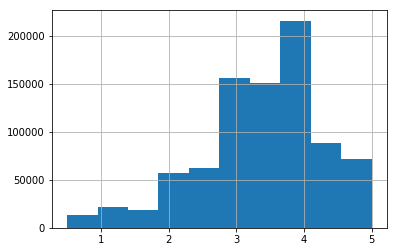

In [3]:
data['rating'].hist()
plt.show()

 Есть 2 разновидности обучения рекомендательных систем: 
 
 1) explicit feedback -- пользователь ставит оценку объекту
 
 2) implicit feedback -- мы понимаем, понравился объект или не понравится по неявному взаимодействию пользователя с системой
 


Как мы в итоге проставлям таргеты?

Все большие рекомендательные системы состоят из двух частей

1) Черновой отбор кандидатов

2) Финальная модель


 Отбираем кандидатов с помощью расстояния

Простые варианты чернового отбора:

1) Самые популярные/новые фильмы

2) Фильмы, которые как-то связаны с человеком

Как свзяны? Какой подход лучше?

Будем пытаться найти в нашей базе похожие фильмы. Если человеку понравился
фильм А, будем для финальной модели отдаваь фильмы, похожие на этот
Возьмем все фильмы, которые понравились пользователям. Базовая гипотеза --  фильмы, которые  смотрят вместе одни люди скорее будут похожими.  


In [4]:
liked_data = data[data.rating >= 3]
print (liked_data.shape)

(682605, 9)


In [5]:
users = list(liked_data['userID'])
movies = list(liked_data['movieID'])

In [6]:
user2movies = {}
for i in range(len(users)):
    user_id = users[i]
    movie_id = movies[i]
    if user_id not in user2movies:
        user2movies[user_id] = set()
    user2movies[user_id].add(movie_id)

### Pointwise mutual information 
Часто используемая мера связи между категориальными признаками. 
$$PMI(x,y) = \log \frac{p(x,y)}{p(x) p(y)} $$
В дискретном случае, если всего $N$ событий и мы хотим посчитать вероятность, что $x, y$ встретились вместе:
$$PMI(x,y) = \log \frac{n_{x,y}  N}{n_x, n_y}, $$
где $n_x - $ число событий где встретилось $x$,  $n_y - $ число событий где встретилось $y, n_{x,y} - $ число событий где встретились вместе $x$ и $y$, $N$ - общее число событий

In [7]:
pairs_count = {}
movies_count = {}
for k, new_user in enumerate(user2movies):
    movies = list(user2movies[new_user])
    for i in range(len(movies)):
        i_movie = movies[i]
        if i_movie not in movies_count:
            movies_count[i_movie] = 0
        movies_count[i_movie] += 1
        for j in range(i + 1, len(movies)):
            j_movie = movies[j]
            assert (i_movie != j_movie)
            if i_movie < j_movie:
                pair = (i_movie, j_movie)
            else:
                pair = (j_movie, i_movie)
            if pair not in pairs_count:
                pairs_count[pair] = 0
            pairs_count[pair] += 1

найдем похожие фильмы на мой любимый по PMI!

In [9]:
movies_data = pd.read_csv('data/movies.dat', sep='\t',  encoding = "ISO-8859-1")
movies_data[movies_data.id == 1 ]

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...


In [10]:
scores = []
REG_THR = 300
for i in pairs_count:
    if pairs_count[i] < REG_THR:
        continue
    score = pairs_count[i] / (movies_count[i[0]] * movies_count[i[1]])
    if i[0] == 1:
        scores.append((score, i[1]))
top_sim_docs = [i[1] for i in sorted(scores, reverse=True)][0:30]

In [11]:
all_words = ""
for i in top_sim_docs:
    new_tile = movies_data[movies_data.id == i ].title.values[0]
    print (new_tile)
    all_words += " " + movies_data[movies_data.id == i ].title.values[0]

Toy Story
A Bug's Life
The Little Mermaid
Snow White and the Seven Dwarfs
Honey, I Shrunk the Kids
Beauty and the Beast
The Lost World: Jurassic Park
Babe
Mary Poppins
Antz
Aladdin
Bill & Ted's Excellent Adventure
Jumanji
Batman Returns
The Lion King
Galaxy Quest
Happy Gilmore
Legally Blonde
A League of Their Own
Batman Forever
Field of Dreams
Clear and Present Danger
Wayne's World
Air Force One
The Wizard of Oz
Fantasia
Twister
Chicken Run
Signs
Home Alone


In [13]:
all_words = ""
for i in top_sim_docs:
    new_tile = movies_data[movies_data.id == i ].title.values[0]
    print (new_tile)
    all_words += " " + movies_data[movies_data.id == i ].title.values[0]

Toy Story
A Bug's Life
The Little Mermaid
Snow White and the Seven Dwarfs
Honey, I Shrunk the Kids
Beauty and the Beast
The Lost World: Jurassic Park
Babe
Mary Poppins
Antz
Aladdin
Bill & Ted's Excellent Adventure
Jumanji
Batman Returns
The Lion King
Galaxy Quest
Happy Gilmore
Legally Blonde
A League of Their Own
Batman Forever
Field of Dreams
Clear and Present Danger
Wayne's World
Air Force One
The Wizard of Oz
Fantasia
Twister
Chicken Run
Signs
Home Alone


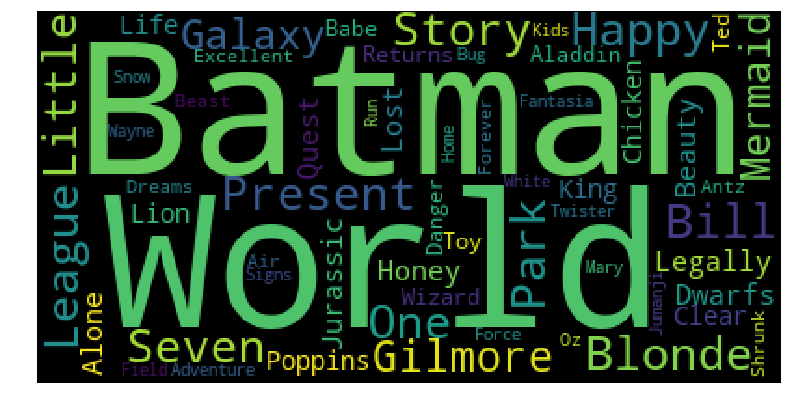

In [18]:
wordcloud = WordCloud().generate(all_words)
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

А как можно применить PMI для поиска синонимов?

https://en.wikipedia.org/wiki/Pointwise_mutual_information